# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [2]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [3]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

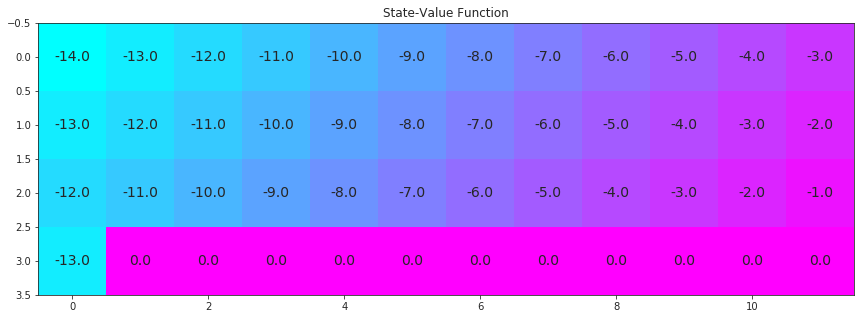

In [4]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [5]:
### John's code

import random

# Determines the action to take in the current state, based on the rules of the Sarsa algorithm.
# Q: current table of state-action values (a list of arrays of possible actions, one array for each state)
# state: the state to be evaluated
# epsilon: the desired probability of choosing a random action
def sarsa_policy(Q, state, epsilon):
    #print("Q[", state, "] = ", Q[state], end="")
    if random.random() < epsilon:
        action = random.randint(0, 3) # anything between 0 and 3, inclusive
        #print(". RANDOM action = ", action)
    else:
        action = np.argmax(Q[state])
        #print(". Policy action = ", action)
    
    return action

In [30]:
### John's code

def sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function to zero, as optimistic values (all action values will be negative)
    Q = defaultdict(lambda: np.zeros(env.nA))

    # set epsilon decay params
    if num_episodes > 5:
        ep0 = 0.2
    else:
        ep0 = 0.5
    epf = 0.01
    ep_rate = ep0/num_episodes
    epsilon = ep0
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        #epsilon = 1.0/i_episode # used by the instructor
        
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{} eps = {:.5f}".format(i_episode, num_episodes, epsilon), end="")
            sys.stdout.flush()   
        
        # set the initial state of the episode and find our first action via the known policy
        s_cur = env.reset()
        a_cur = sarsa_policy(Q, s_cur, epsilon)
        
        # loop until the episode is finished
        done = False
        while not done:
            
            # get the expected reward from the current state/action pair
            expected_val_cur = Q[s_cur][a_cur]
            #print("s_cur = ", s_cur, ", a_cur = ", a_cur, ", ev_cur = ", expected_val_cur)

            # execute that action to find the reward and next state
            s_next, r_next, done, info = env.step(a_cur)
            #print("s_next= ", s_next, end="")
            
            # get the next action based on the current Q table, then find the expected reward for it
            if done:
                a_next = -1
                expected_val_next = 0.0
            else:
                a_next = sarsa_policy(Q, s_next, epsilon)
                expected_val_next = Q[s_next][a_next]
            #print(" , a_next= ", a_next, ", r_next=", r_next, ", ev_next=", expected_val_next)
            #print("Before update:                             Q[", s_cur, ",] = ", Q[s_cur])
            
            # compute the update for the current Q entry
            term1 = r_next + gamma*expected_val_next - expected_val_cur
            delta = alpha*term1
            Q[s_cur][a_cur] += delta
            #print("term1 = ", term1, ", delta = ", delta, ", new Q row = ", Q[s_cur], end="\n\n")
            
            # the game environment has already advanced us to the next state; we now need
            # to catch up our internal bookkeeping with that
            s_cur = s_next
            a_cur = a_next

        # decay epsilon for next episode
        epsilon -= ep_rate
        if epsilon < epf:
            epsilon = epf

    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 50000/50000 eps = 0.01000

**<span style="color: red;">PLEASE TRY AGAIN</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0  0  0  0  0  0  0  0  0  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


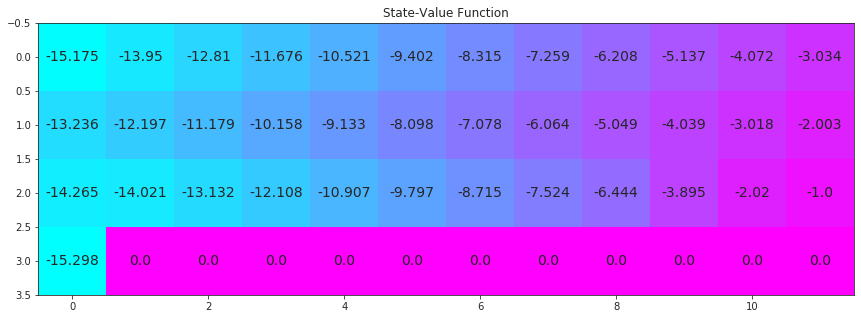

In [31]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 50000, 0.01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [52]:
### John's code

def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function to zero, as optimistic values (all action values will be negative)
    Q = defaultdict(lambda: np.zeros(env.nA))

    # set epsilon decay params
    if num_episodes > 5:
        ep0 = 0.8
    else:
        ep0 = 0.5
    epf = 0.01
    ep_rate = ep0/num_episodes
    epsilon = ep0
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        #epsilon = 1.0/i_episode # used by the instructor
        
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{} eps = {:.5f}".format(i_episode, num_episodes, epsilon), end="")
            sys.stdout.flush()   
        
        # set the initial state of the episode and find our first action via the known policy
        s_cur = env.reset()
        a_cur = sarsa_policy(Q, s_cur, epsilon)
        
        # loop until the episode is finished
        done = False
        while not done:
            
            # get the expected reward from the current state/action pair
            expected_val_cur = Q[s_cur][a_cur]
            #print("s_cur = ", s_cur, ", a_cur = ", a_cur, ", ev_cur = ", expected_val_cur)

            # execute that action to find the reward and next state
            s_next, r_next, done, info = env.step(a_cur)
            #print("s_next= ", s_next, end="")
            
            # get the next action based on the current Q table, then find the expected reward for it
            if done:
                a_next = -1
                expected_val_next = 0.0
            else:
                a_temp = np.argmax(Q[s_next]) #this line is different from Sarsa
                expected_val_next = Q[s_next][a_temp]
                a_next = sarsa_policy(Q, s_next, epsilon) #use eps-greedy policy to choose actual next action
            #print(", Q[", s_next, "] = ", Q[s_next], ", a_next = ", a_next, ", ev_next = ", expected_val_next)
            #print(" , a_next= ", a_next, ", r_next=", r_next, ", ev_next=", expected_val_next)
            #print("Before update:                             Q[", s_cur, ",] = ", Q[s_cur])
            
            # compute the update for the current Q entry
            term1 = r_next + gamma*expected_val_next - expected_val_cur
            delta = alpha*term1
            Q[s_cur][a_cur] += delta
            #print("term1 = ", term1, ", delta = ", delta, ", new Q row = ", Q[s_cur], end="\n\n")
            
            # the game environment has already advanced us to the next state; we now need
            # to catch up our internal bookkeeping with that
            s_cur = s_next
            a_cur = a_next

        # decay epsilon for next episode
        epsilon -= ep_rate
        if epsilon < epf:
            epsilon = epf

    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000 eps = 0.01000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


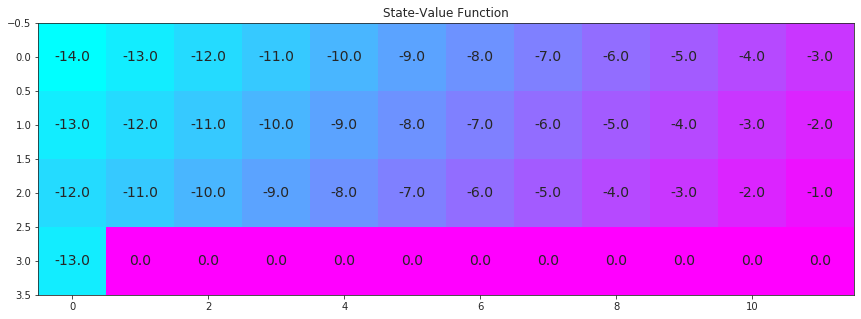

In [53]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .1)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [50]:
### John's code

# Computes the next step's expected value based on epsilon-greedy probabilities of each action for 
# the given state
# Q:  current table of state-action values; a dictionary of 1D arrays of action values, one array per state
# s:  the state in question
# epsilon:  the fraction of trials that will be random
# Returns the expected value of the state
def expected_sarsa_policy(Q, s, epsilon):
    # find the first greedy action (the one with highest estimated return)
    actions = Q[s]
    greedy_action = []
    greedy_action.append(np.argmax(actions))
    g1 = actions[greedy_action[0]]
    
    # if there are other actions with equally high returns, consider them greedy as well
    tolerance = 1.0e-4
    num_greedy = 0 #g1 identified above will be counted in this loop as well
    for i, a in enumerate(actions):
        if a >= g1 - tolerance:
            greedy_action.append(i)
            num_greedy += 1
    
    # Determine the probabilities associated with each type of action
    prob_greedy = (1.0 - epsilon)/num_greedy + epsilon/len(actions)
    prob_not_greedy = epsilon/len(actions)
    #print("Policy: actions = ", actions, ", prob_greedy = ", prob_greedy, ", prob_NG = ", prob_not_greedy)
    
    # sum the target values
    value = 0.0
    for i in range(len(actions)):
        if i in greedy_action:
            value += actions[i]*prob_greedy
        else:
            value += actions[i]*prob_not_greedy
    
    #print("Policy returning value ", value)
    return value

def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function to zero, as optimistic values (all action values will be negative)
    Q = defaultdict(lambda: np.zeros(env.nA))

    # set epsilon decay params
    if num_episodes > 5:
        ep0 = 0.01 ### if I set this to 0.5 or similar, the solution path takes the top of the grid
    else: #for debugging only
        ep0 = 0.5
    epf = 0.01
    ep_rate = ep0/num_episodes
    epsilon = ep0
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        #epsilon = 1.0/i_episode # used by the instructor
        
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{} eps = {:.5f}".format(i_episode, num_episodes, epsilon), end="")
            sys.stdout.flush()   
        
        # set the initial state of the episode and find our first action via the known policy
        s_cur = env.reset()
        
        # loop until the episode is finished
        done = False
        while not done:
            
            # get the action and expected reward from the current state
            a_cur = sarsa_policy(Q, s_cur, epsilon)
            expected_val_cur = Q[s_cur][a_cur]
            #print("s_cur = ", s_cur, ", a_cur = ", a_cur, ", ev_cur = ", expected_val_cur)

            # execute that action to find the reward and next state
            s_next, r_next, done, info = env.step(a_cur)
            #print("s_next= ", s_next, end="")
            
            # find the expected reward from the next state based on probabilities of all actions
            if done:
                expected_val_next = 0.0
            else:
                expected_val_next = expected_sarsa_policy(Q, s_next, epsilon)
            #print(", Q[", s_next, "] = ", Q[s_next], ", ev_next = ", expected_val_next)
            #print(", r_next=", r_next, ", ev_next=", expected_val_next)
            #print("Before update:                             Q[", s_cur, ",] = ", Q[s_cur])
            
            # compute the update for the current Q entry
            target  = r_next + gamma*expected_val_next
            delta = alpha*(target - expected_val_cur)
            Q[s_cur][a_cur] += delta
            #print("target = ", target, ", delta = ", delta, ", new Q row = ", Q[s_cur], end="\n\n")
            
            # the game environment has already advanced us to the next state; we now need
            # to catch up our internal bookkeeping with that
            s_cur = s_next

        # decay epsilon for next episode
        epsilon -= ep_rate
        if epsilon < epf:
            epsilon = epf

    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000 eps = 0.01000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  0  1  1  1  1  1  0  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


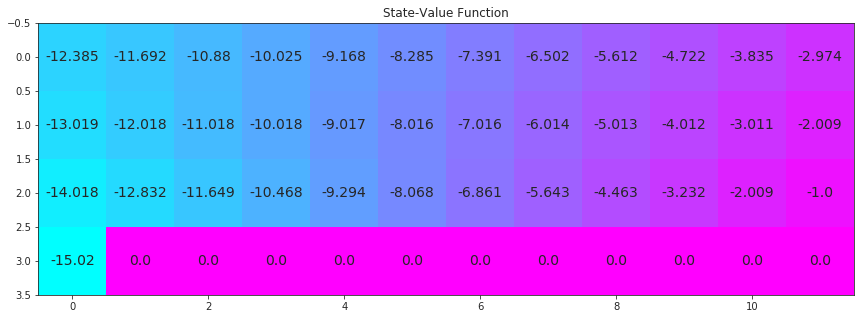

In [51]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 5000, 0.1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])